In [236]:
import sys
sys.path.append('src/features')

In [237]:
import pandas as pd
import numpy as np

from datetime import timedelta
from datetime import datetime

import re

import matplotlib.pyplot as plt
import seaborn as sns

In [238]:
import customplots
from customplots import target_features_plot, grid_serach_dt, col_import_plot

from dates_processor import *

In [239]:
import warnings
warnings.filterwarnings('ignore')

In [240]:
# Train data
data=pd.read_csv('data/mimic_train.csv')
print(data.shape)
data.head()

(20885, 44)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [241]:
# Test dataset (to produce predictions)
data_test=pd.read_csv('data/mimic_test_death.csv')
print(data_test.shape)
data_test.sort_values('icustay_id').head()

(5221, 39)


,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [242]:
# I see that there are some columns in training not in test, let's keep the same in both
print([col for col in data.columns if col not in data_test.columns])

['HOSPITAL_EXPIRE_FLAG', 'DOD', 'DISCHTIME', 'DEATHTIME', 'LOS']


In [243]:
data.drop(['DOD', 'DISCHTIME', 'DEATHTIME', 'LOS'], axis = 1, inplace=True)
print(data.shape)
print(data_test.shape)

(20885, 40)
(5221, 39)


## Data exploration and feature engineering

### Target variable

0.11228154177639454
0    18540
1     2345
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64


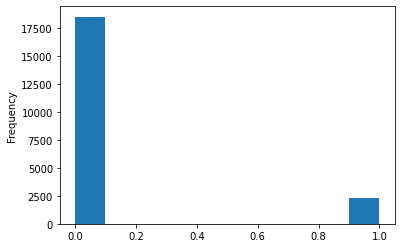

In [244]:
# Target variable
data['HOSPITAL_EXPIRE_FLAG'].plot(kind='hist')
print(data['HOSPITAL_EXPIRE_FLAG'].mean())
print(data['HOSPITAL_EXPIRE_FLAG'].value_counts())

In [245]:
# Join both train and test
data['from'] = 'train'
data_test['from'] = 'test'
df = pd.concat([data, data_test], axis = 0)
df.reset_index(inplace=True, drop=True)
print(df.shape)

(26106, 41)


### Dates and age

In [246]:
### Adjusting the format of the dates
df['DOB'] = pd.to_datetime(df['DOB'])
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])

In [247]:
# Adjust days using diff
df['Diff_days'] = df['Diff'].apply(np.floor).apply(lambda x: pd.Timedelta(x, unit='D'))
df['DOB'] = df['DOB'] + df['Diff_days']
df['ADMITTIME'] = df['ADMITTIME'] + df['Diff_days']
print(df['ADMITTIME'].dt.year.value_counts())
print(df['DOB'].dt.year.value_counts())

2008    6548
2009    5211
2010    5180
2011    5158
2012    4000
2007       9
Name: ADMITTIME, dtype: int64
1944    660
1946    605
1945    605
1947    597
1943    594
       ... 
1704     14
1994      8
1701      5
1995      4
1996      1
Name: DOB, Length: 90, dtype: int64


In [248]:
# Adjust the hours
df['Diff_h'] = ((np.abs(df['Diff']) % 1) * -24).round() # Number of hours to rest from the date according to the decimal points of Diff
df['Diff_h'] = df['Diff_h'].apply(lambda x: pd.Timedelta(x, unit='h'))
print(df['ADMITTIME'])
df['ADMITTIME'] = df['ADMITTIME'] + df['Diff_h']
print(df['ADMITTIME'])

0       2008-06-15 10:35:00
1       2010-12-26 22:34:00
2       2010-11-10 23:04:00
3       2011-09-26 08:00:00
4       2008-09-12 02:02:00
                ...        
26101   2008-05-31 11:01:00
26102   2008-04-03 10:45:00
26103   2009-12-17 04:04:00
26104   2011-11-22 07:15:00
26105   2011-08-20 07:15:00
Name: ADMITTIME, Length: 26106, dtype: datetime64[ns]
0       2008-06-14 15:35:00
1       2010-12-26 18:34:00
2       2010-11-10 00:04:00
3       2011-09-25 23:00:00
4       2008-09-11 08:02:00
                ...        
26101   2008-05-30 20:01:00
26102   2008-04-03 08:45:00
26103   2009-12-16 06:04:00
26104   2011-11-22 04:15:00
26105   2011-08-19 16:15:00
Name: ADMITTIME, Length: 26106, dtype: datetime64[ns]


In [249]:
# Compute the age (it does not need to be exactly)
df['AGE']  = df['ADMITTIME'].dt.year - df['DOB'].dt.year

In [250]:
# Using my processor for the creation of year, month, day , weekday and hour from a date column
dates_p = DatesPreprocessor()
df_d = dates_p.preprocess(df, ['ADMITTIME'])

In [251]:
# Delete columns I don't need
df_d = df_d.drop(['Diff', 'Diff_days', 'Diff_h'], axis=1)
df_d.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'from', 'AGE', 'ADMITTIME_year',
       'ADMITTIME_month', 'ADMITTIME_day', 'ADMITTIME_weekday',
       'ADMITTIME_hour'],
      dtype='object')

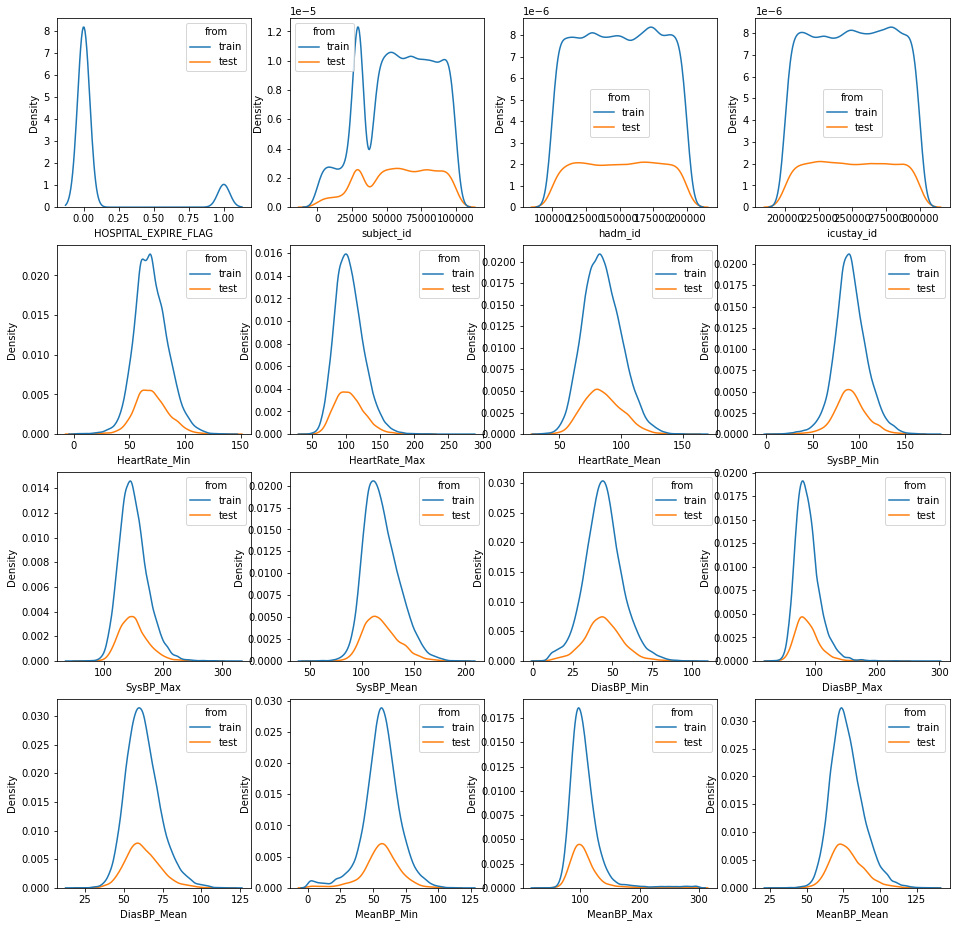

In [252]:
# Plot distribution of numeric features for train and test
target_features_plot(df_d, 'from', df_d.select_dtypes('number').columns[:16], 'density')

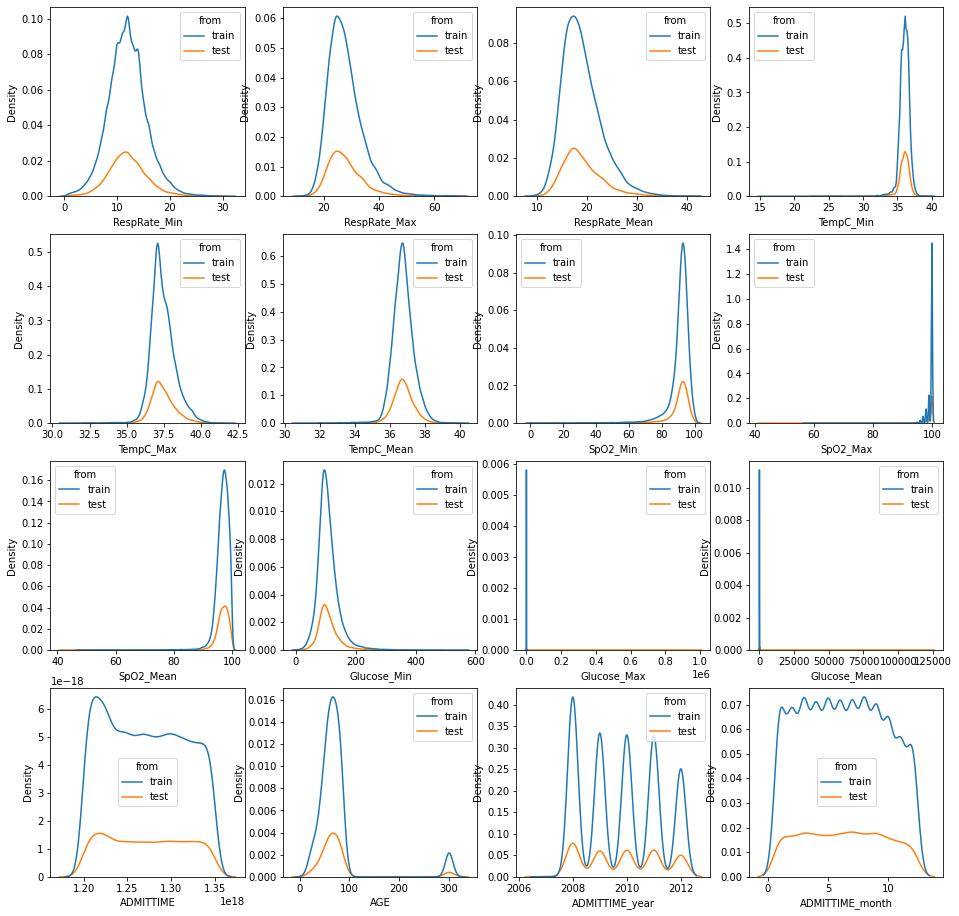

In [253]:
target_features_plot(df_d, 'from', df_d.select_dtypes('number').columns[16:32], 'density')

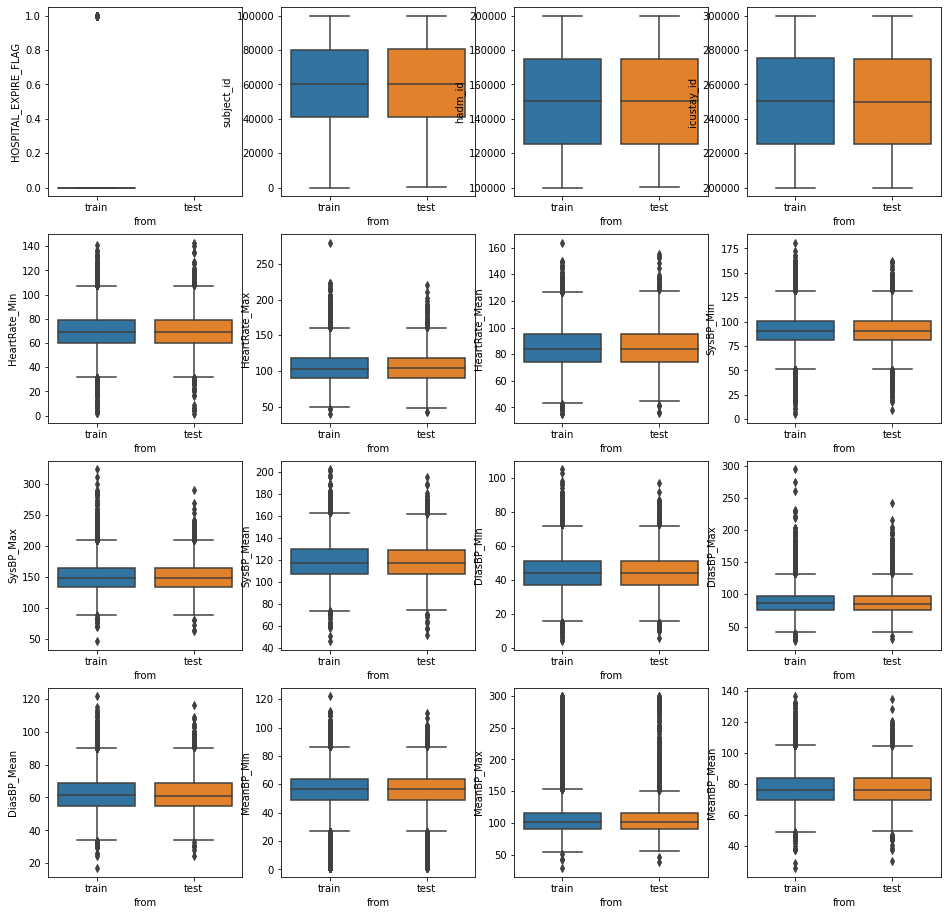

In [254]:
target_features_plot(df_d, 'from', df_d.select_dtypes('number').columns[:16], 'boxplot')

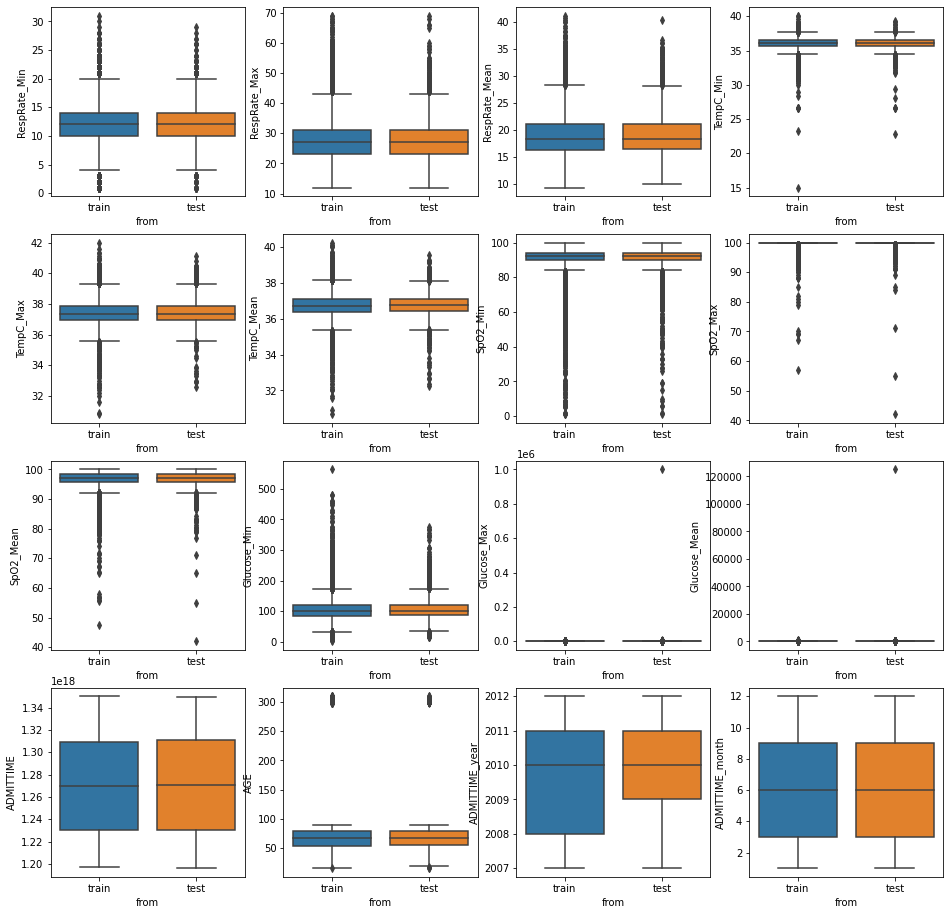

In [255]:
target_features_plot(df_d, 'from', df_d.select_dtypes('number').columns[16:32], 'boxplot')

The distribution of the features is similar in both test and train data

### ICD9_diagnosis

Seeing the List of ICD-9 codes I realize that many ICD9 are wrong https://en.wikipedia.org/wiki/List_of_ICD-9_codes

It's a 3 digits of letter + 3 digits code

In [256]:
def fix_ICD9(text):
    text = re.sub(r'^0', r'', text) # replace those that start with ceros
    text = re.sub(r'(\d{3})(\d{2})', r'\1.\2', text) # include . when it has 5 digits
    text = re.sub(r'(\d{3})(\d{1})', r'\1.\2', text) # include . when it has 4 digits
    text = re.sub(r'(E)(\d+)', r'19\2', text) # replace E with 19
    text = re.sub(r'(V)(\d+)', r'29\2', text) # replace V with 29
    return text
    
df_g = df_d.copy()
df_g['ICD9_diagnosis2'] = df_g['ICD9_diagnosis'].apply(fix_ICD9).astype(float)

In [257]:
df_g['ICD9_L1'] = pd.cut(x = df_g['ICD9_diagnosis2'], 
                         bins = [0, 139, 239, 279, 289, 319, 389, 459, 519, 579, 629, 679, 709, 739, 759, 779, 799, 999, df_g['ICD9_diagnosis2'].max()], 
                         labels=False)
df_g[['ICD9_L1', 'ICD9_diagnosis2']].head()

,ICD9_L1,ICD9_diagnosis2
0,8,578.90
1,8,530.13
2,8,569.83
3,8,553.30
4,8,562.11


<AxesSubplot:xlabel='ICD9_L1', ylabel='HOSPITAL_EXPIRE_FLAG'>

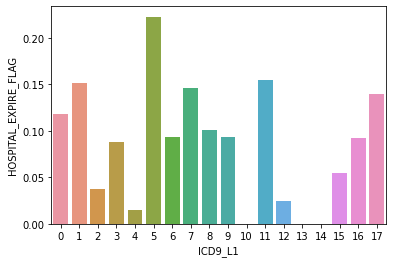

In [258]:
data_res = df_g.groupby('ICD9_L1').mean()['HOSPITAL_EXPIRE_FLAG'].to_frame().reset_index()
sns.barplot(x='ICD9_L1', y = 'HOSPITAL_EXPIRE_FLAG', data = data_res)

The ICD9 level 1 codes where the proportion of death is higher are 5: diseases of the nervous system and sense organs; 11: diseases of the skin and subcutaneous tissue; 17 : external causes of injury and 7:  diseases of the respiratory system.

On the other hand the, groups witht less proportion of deaths are 4: mental disorders; 10: complications of pregnancy, childbirth, and the puerperium; 13: congenital anomalies and 14: certain conditions originating in the perinatal period. 

The above 

<AxesSubplot:xlabel='ICD9_diagnosis2', ylabel='death_mean'>

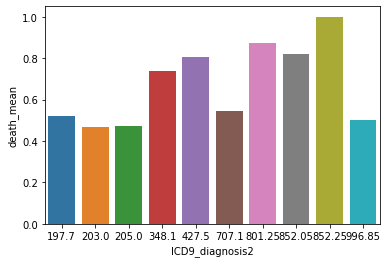

In [259]:
data_res_2 = df_g.groupby('ICD9_diagnosis2').agg({'HOSPITAL_EXPIRE_FLAG': ['mean', 'size']}).reset_index()
data_res_2.columns = ['ICD9_diagnosis2', 'death_mean', 'death_size']
data_res_2.sort_values(by='death_mean', ascending=False, inplace=True)

sns.barplot(x='ICD9_diagnosis2', y = 'death_mean', data = data_res_2[data_res_2['death_size']>10].head(10))

There are other diagnosis that have more correlation with the death of a patient. However, other 3-digit categories have only one or two patients with a proportion of death of 1.

In [260]:
df_g['ICD9_diagnosis3'] = np.floor(df_g['ICD9_diagnosis2']) # Get only the integer value
print(df_g['ICD9_diagnosis3'].nunique())
print(df_g['ICD9_diagnosis3'].value_counts())

564
414.0    1400
389.0    1229
410.0    1167
424.0     939
428.0     834
         ... 
830.0       1
159.0       1
545.0       1
987.0       1
520.0       1
Name: ICD9_diagnosis3, Length: 564, dtype: int64


<AxesSubplot:xlabel='ICD9_diagnosis3', ylabel='death_mean'>

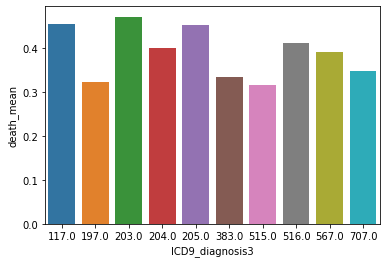

In [261]:
data_res_3 = df_g.groupby('ICD9_diagnosis3').agg({'HOSPITAL_EXPIRE_FLAG': ['mean', 'size']}).reset_index()
data_res_3.columns = ['ICD9_diagnosis3', 'death_mean', 'death_size']
data_res_3.sort_values(by='death_mean', ascending=False, inplace=True)

sns.barplot(x='ICD9_diagnosis3', y = 'death_mean', data = data_res_3[data_res_3['death_size']>10].head(10))

Taking into account only the integer value of the code. The results are better...

In [262]:
# Group 3 digits codes with 2 or less patients as other 9999
df_g['Count_3d'] = df_g.groupby('ICD9_diagnosis3')['subject_id'].transform("count")
df_g['ICD9_diagnosis3'] = np.where(df_g['Count_3d']<=2, 9999, df_g['ICD9_diagnosis3'])
df_g.drop(['Count_3d'],axis=1, inplace=True)
print(df_g['ICD9_diagnosis3'].nunique())
print(df_g['ICD9_diagnosis3'].value_counts())

390
414.0    1400
389.0    1229
410.0    1167
424.0     939
428.0     834
         ... 
492.0       3
307.0       3
759.0       3
194.0       3
716.0       3
Name: ICD9_diagnosis3, Length: 390, dtype: int64


In [263]:
df_g['ICD9_diagnosis_dec'] = df_g['ICD9_diagnosis2'] % 1 # Get the decimal value

df_g['Count_dec'] = df_g.groupby('ICD9_diagnosis_dec')['subject_id'].transform("count")
df_g['ICD9_diagnosis_dec'] = np.where(df_g['Count_dec']<=2, 9999, df_g['ICD9_diagnosis_dec'])
df_g.drop(['Count_dec'],axis=1, inplace=True)

print(df_g['ICD9_diagnosis_dec'].value_counts())
print(df_g['ICD9_diagnosis_dec'].nunique())

0.00    5755
0.10    2114
0.01    1916
0.90    1204
0.40     784
        ... 
0.29       3
0.04       3
0.23       3
0.38       3
0.09       3
Name: ICD9_diagnosis_dec, Length: 137, dtype: int64
137


In [264]:
# delete other columns of diagnosis and convert categories to object type
df_g.drop(['ICD9_diagnosis', 'ICD9_diagnosis2', 'DIAGNOSIS'], axis=1, inplace=True)
df_g[['ICD9_diagnosis3', 'ICD9_diagnosis_dec', 'ICD9_diagnosis3', 'ICD9_L1']] = df_g[['ICD9_diagnosis3', 'ICD9_diagnosis_dec', 'ICD9_diagnosis3', 'ICD9_L1']].astype('object')

### ID column  as index

In [265]:
#### ID column  as index
df_i = df_g.copy()
df_i.set_index(['icustay_id'], inplace=True)
df_i.drop(['subject_id', 'hadm_id'], axis=1, inplace=True)
df_i.head()

,HOSPITAL_EXPIRE_FLAG,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,...,from,AGE,ADMITTIME_year,ADMITTIME_month,ADMITTIME_day,ADMITTIME_weekday,ADMITTIME_hour,ICD9_L1,ICD9_diagnosis3,ICD9_diagnosis_dec
icustay_id,,,,,,,,,,,,,,,,,,,,,
228357,0.0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,...,train,70,2008,6,14,5,15,8,578,0.9
221004,0.0,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,...,train,42,2010,12,26,6,18,8,530,0.13
296315,0.0,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,...,train,68,2010,11,10,2,0,8,569,0.83
245557,0.0,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,...,train,75,2011,9,25,6,23,8,553,0.3
225281,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,train,79,2008,9,11,3,8,8,562,0.11


### Missing values

In [266]:
df_i.isnull().mean()

HOSPITAL_EXPIRE_FLAG    0.199992
HeartRate_Min           0.104650
HeartRate_Max           0.104650
HeartRate_Mean          0.104650
SysBP_Min               0.105685
SysBP_Max               0.105685
SysBP_Mean              0.105685
DiasBP_Min              0.105761
DiasBP_Max              0.105761
DiasBP_Mean             0.105761
MeanBP_Min              0.104689
MeanBP_Max              0.104689
MeanBP_Mean             0.104689
RespRate_Min            0.104765
RespRate_Max            0.104765
RespRate_Mean           0.104765
TempC_Min               0.120087
TempC_Max               0.120087
TempC_Mean              0.120087
SpO2_Min                0.105493
SpO2_Max                0.105493
SpO2_Mean               0.105493
Glucose_Min             0.011913
Glucose_Max             0.011913
Glucose_Mean            0.011913
GENDER                  0.000000
DOB                     0.000000
ADMITTIME               0.000000
ADMISSION_TYPE          0.000000
INSURANCE               0.000000
RELIGION  

In [267]:
# Create new columns that report if the row-column is missing or not
df_m = df_i.copy()
for col in df_m.columns[df_m.isnull().mean() > 0]:
    df_m[col+'_isna'] = df_m[col].isna()

print(len(df_i.columns))
print(len(df_m.columns))

44
70


In [268]:
df_m.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'from', 'AGE',
       'ADMITTIME_year', 'ADMITTIME_month', 'ADMITTIME_day',
       'ADMITTIME_weekday', 'ADMITTIME_hour', 'ICD9_L1', 'ICD9_diagnosis3',
       'ICD9_diagnosis_dec', 'HOSPITAL_EXPIRE_FLAG_isna', 'HeartRate_Min_isna',
       'HeartRate_Max_isna', 'HeartRate_Mean_isna', 'SysBP_Min_isna',
       'SysBP_Max_isna', 'SysBP_Mean_isna', 'DiasBP_Min_isna',
       'DiasBP_Max_isna', 'DiasBP_Mean_isna', 'MeanBP_Min_isna',
       'MeanBP_Max

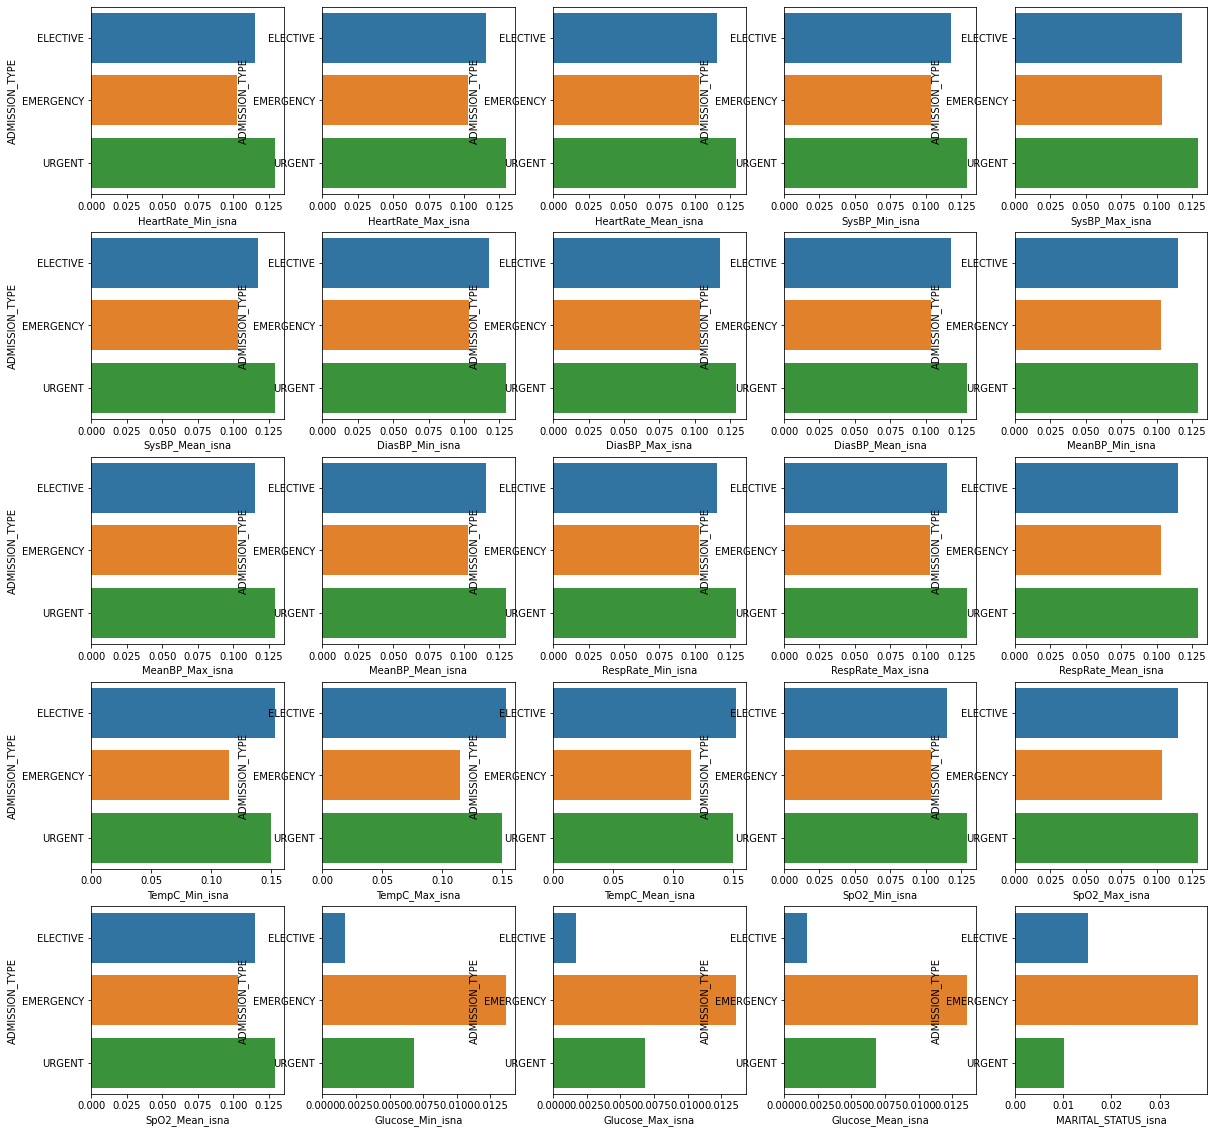

In [269]:
# Addmision type can explain missing values
na_columns = [col for col in df_m.columns if 'isna' in col][1:] # List of na columnsn without HOSPITAL_EXPIRE_FLAG
na_at = df_m.groupby('ADMISSION_TYPE')[na_columns].mean()

plt.figure(figsize=(20, 20))
for i,col in enumerate(na_columns):
            plt.subplot(5,5,i+1)
            sns.barplot(x=na_at[col], y=na_at.index)

It seems like the information of Glucose and Marital Status is not gathered in the emergency admissions

#### Split data for imputation

In [270]:
y_train = df_m[df_m['from'] == 'train']['HOSPITAL_EXPIRE_FLAG']
X_train = df_m[df_m['from'] == 'train'].drop(['from', 'HOSPITAL_EXPIRE_FLAG'], axis=1)
X_test = df_m[df_m['from'] == 'test'].drop(['from', 'HOSPITAL_EXPIRE_FLAG'], axis=1)

print(y_train.shape, X_train.shape, X_test.shape)

(20885,) (20885, 68) (5221, 68)


In [302]:
# Fill marital estatus with the most common by the group age
X_train['AGE_GROUP'] = pd.cut(X_train['AGE'], [i for i in range(0, X_train['AGE'].max(), 5)], labels=False)

X_train['MARITAL_STATUS'].fillna(X_train.groupby(['AGE_GROUP'])['MARITAL_STATUS'].transform(lambda x: x.value_counts().idxmax()), inplace=True)
X_test['MARITAL_STATUS'].fillna(X_train.groupby(['AGE_GROUP'])['MARITAL_STATUS'].transform(lambda x: x.value_counts().idxmax()), inplace=True)


ValueError: Length mismatch: Expected axis has 20824 elements, new values have 20885 elements

In [303]:
#X_train['MARITAL_STATUS'].value_counts().idxmax()
#X_train['MARITAL_STATUS'].mode()[0]
X_train.groupby(['AGE_GROUP'])['MARITAL_STATUS'].transform(lambda x: x.mode().iloc[0])
#X_train.groupby(['GENDER', 'AGE_GROUP'])['MARITAL_STATUS'].mode()[0]
#X_train.info()

ValueError: Length mismatch: Expected axis has 20824 elements, new values have 20885 elements

#### Imputation

In [234]:
X_train.isnull().mean()

HeartRate_Min          0.104716
HeartRate_Max          0.104716
HeartRate_Mean         0.104716
SysBP_Min              0.105722
SysBP_Max              0.105722
                         ...   
SpO2_Mean_isna         0.000000
Glucose_Min_isna       0.000000
Glucose_Max_isna       0.000000
Glucose_Mean_isna      0.000000
MARITAL_STATUS_isna    0.000000
Length: 67, dtype: float64

In [ ]:
from sklearn.impute import IterativeImputer
KNeighborsRegressor(n_neighbors=2)

start_time = datetime.now()

my_imputer=IterativeImputer(random_state=0, estimator=, max_iter=30,add_indicator=True)
my_imputer.fit(X_train7)

X_train = my_imputer.transform(X_train)
X_test = my_imputer.transform(X_train)
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))